In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import ABCDeqs

import scipy.optimize as opt

%matplotlib inline

from pyConstants import *
from SrConstants import *

### Let's test how the assumptions for fiber collimation work 

Let's define a q-param for a beam exiting a fiber as having R=infinity (because the fiber has a flat facet, so let's assume a flat wavefront
Let's define w0 as the width coming from the fiber spec sheet mode field diameter (MFD), well divided by 2 because here it's radius
Then let's calculate how well the beam gets collimated by a particular collimating lens and what the collimated spot size is 

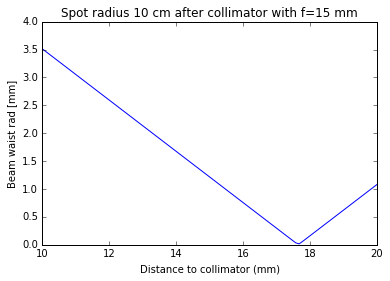

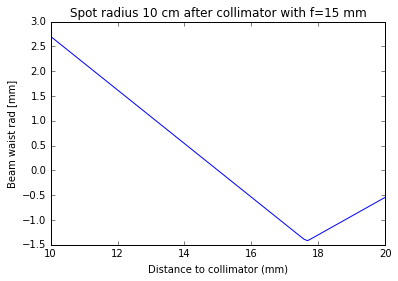

In [2]:
# Define all params in mm

w0 = 0.5*3.62e-3 #radius from mean field diameter (MFD) calculated from Thorlabs datasheet for blue fiber 
# https://www.thorlabs.com/drawings/ca48bce60700f2ea-A1CF1A73-5056-0103-7926B34815E79ED6/PM-S405-XP-SpecSheet.pdf
lam = 461e-6 #blue light
qIn = ABCDeqs.q_param(lam,w0,np.inf) #q-parameter assuming planar wavefront at fiber exit, with waist = MFD/2
collimatorF = 15 #collimator focal length

distToCollimator = np.linspace(10,20,num=100)
waists = [] #radius of the waist 10 cm after collimating lens 
waistDiffs = [] #difference in waist right after the collimator and 10 cm further

for d in distToCollimator:
    #set up ABCD matrices
    beforeCollimator = ABCDeqs.space_matrix(d,1)
    collimator = ABCDeqs.lens_matrix(collimatorF)
    afterCollimator = ABCDeqs.space_matrix(100,1) #100 mm afterwards
    
    #get q after propagation 
    qAfterLens = ABCDeqs.propagate_q(qIn,collimator*beforeCollimator)
    q10cmFurther = ABCDeqs.propagate_q(qIn,afterCollimator*collimator*beforeCollimator)
    
    waistAfterLens = ABCDeqs.waist_from_q(qAfterLens,lam)
    waist10cmFurther = ABCDeqs.waist_from_q(q10cmFurther,lam)
    
    waists.append(waist10cmFurther)
    waistDiffs.append(waist10cmFurther-waistAfterLens)
    
plt.plot(distToCollimator,waists)
plt.title("Spot radius 10 cm after collimator with f=%.i mm" % collimatorF)
plt.xlabel("Distance to collimator (mm)")
plt.ylabel("Beam waist rad [mm]")
plt.show()

plt.plot(distToCollimator,waistDiffs)
plt.title("Spot radius 10 cm after collimator with f=%.i mm" % collimatorF)
plt.xlabel("Distance to collimator (mm)")
plt.ylabel("Beam waist rad [mm]")
plt.show()

#plt.plot(lenvalues,waists)

## ZS beam calculations

In [3]:
# Define functions

# Width evolution of a Gaussian beam from a particular minimum waist w0 (w0 defines radius, not diam)
def w_Gauss_freespace(dist,w0,lam):
    zR = (np.pi*w0**2)/lam # Rayleigh range 
    width = w0*np.sqrt(1+(dist/zR)**2)
    return width 

# Find the position and size of the focus spot of the Gaussian beam from the values of the spot size at 
# two different positions
# This function is used as the first parameter (callable) into scipy.optimize.fsolve
def spotsize_optimize(vars_to_opt,w0_1,w0_2,distance):

    # We take the unknowns
    (z,w0) = vars_to_opt
    
    # We define the system of nonlinear equations using the eqs for Gaussian beam spot size evolution 
    # defined above 
    # According to the scipy.optimize.fsolve routine, the functions need to be defined so that at the 
    # optimal value of the parameters we get the roots, meaning there's zero on one side of the equation 
    
    zero_w0_1 = w_Gauss_freespace(z,w0,lam)-w0_1 
    zero_w0_2 = w_Gauss_freespace((z-distance),w0,lam)-w0_2 

    return [zero_w0_1,zero_w0_2]

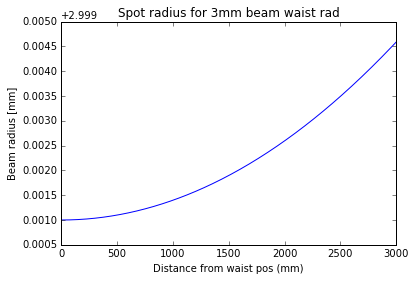

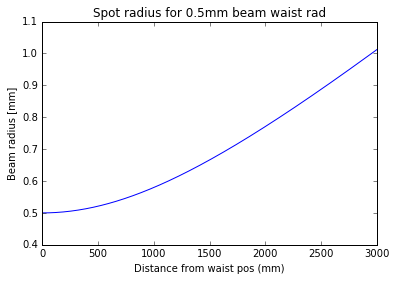

In [4]:
# Plot the variation of Gaussian spot size 

distpts = np.linspace(0,3000,400) #assume points from the min waist position up to 3m further 

plt.plot(distpts,w_Gauss_freespace(distpts,3,lam))
plt.title("Spot radius for 3mm beam waist rad")
plt.xlabel("Distance from waist pos (mm)")
plt.ylabel("Beam radius [mm]")
plt.show()

plt.plot(distpts,w_Gauss_freespace(distpts,0.5,lam))
plt.title("Spot radius for 0.5mm beam waist rad")
plt.xlabel("Distance from waist pos (mm)")
plt.ylabel("Beam radius [mm]")
plt.show()

#NOTE 3 mm is effectively a nondiverging beam for our machine size 

For the optimization for the beam passing thhrough the apertures at the end of the short ZS and         the beginning of the long ZS, the position of the end of the short ZS is 4018.7412 mm and the minimum waist         rad is 0.0983 mm 
 Vertical line is the position of the         end of the short ZS


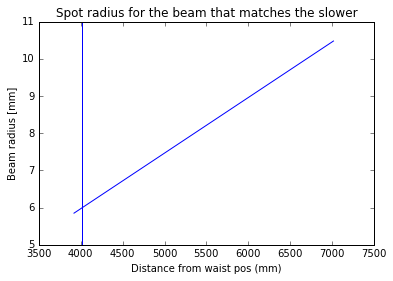

In [5]:
# Now given the nonlinear equations w_Gauss_freespace configured within spotsize_optimize let's solve 
# the nonlinear equations to get the actual minimum waist position and size, and thus be able to propagate this beam 
# including with ABCD matrices 
                       
w0_EndShortZS = 6 #6 mm is the beam rad that passes >99% through 21 mm aperture
w0_StartLongZS = 4.5 #4.5 mm is the beam rad that passes >99% through 16 mm aperture
dist_StartToEndZS = 1005 # from measurement on the machine 
solution_ZSfrontback = opt.fsolve(spotsize_optimize,[1500,0.5],args=(w0_EndShortZS,w0_StartLongZS,dist_StartToEndZS))

print("For the optimization for the beam passing thhrough the apertures at the end of the short ZS and \
        the beginning of the long ZS, the position of the end of the short ZS is %.4f mm and the minimum waist \
        rad is %.4f mm \n Vertical line is the position of the \
        end of the short ZS" % (solution_ZSfrontback[0],solution_ZSfrontback[1]))      

pts_afterShortZS = np.linspace(solution_ZSfrontback[0]-100,solution_ZSfrontback[0]+3000,300)
plt.plot(pts_afterShortZS,w_Gauss_freespace(pts_afterShortZS,solution_ZSfrontback[1],lam))
plt.axvline(x=solution_ZSfrontback[0])
plt.title("Spot radius for the beam that matches the slower")
plt.xlabel("Distance from waist pos (mm)")
plt.ylabel("Beam radius [mm]")
plt.show()

For the optimization for the beam passing thhrough the apertures at the end of the short ZS and         end of the diff tube, the position of the end of the short ZS is 2459.6644 mm and the minimum waist         rad is 0.06016 mm 
 Vertical line is the position of the         end of the short ZS


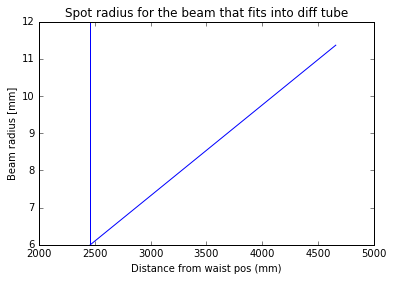

In [6]:
w0_EndShortZS = 6 #6 mm is the beam rad that passes >99% through 21 mm aperture
w0_EndDiffTube = 3.5 #3.5 mm is the beam rad that passes ~95% into 9 mm aperture of the diff tube
dist_StartZStoDiffTube = 1025 # from measurement on the machine, it's 20 mm before the start of the long ZS
solution_ZStoDiffTube = opt.fsolve(spotsize_optimize,[1500,0.5],args=(w0_EndShortZS,w0_EndDiffTube,dist_StartZStoDiffTube))

print("For the optimization for the beam passing thhrough the apertures at the end of the short ZS and \
        end of the diff tube, the position of the end of the short ZS is %.4f mm and the minimum waist \
        rad is %.5f mm \n Vertical line is the position of the \
        end of the short ZS" % (solution_ZStoDiffTube[0],solution_ZStoDiffTube[1]))      

pts_afterShortZS = np.linspace(solution_ZStoDiffTube[0],solution_ZStoDiffTube[0]+2200,300)
plt.plot(pts_afterShortZS,w_Gauss_freespace(pts_afterShortZS,solution_ZStoDiffTube[1],lam))
plt.axvline(x=solution_ZStoDiffTube[0])
#plt.axvline(x=4000)
plt.title("Spot radius for the beam that fits into diff tube")
plt.xlabel("Distance from waist pos (mm)")
plt.ylabel("Beam radius [mm]")
plt.show()

Now let's evolve the beam above directly through the ABCD matrix propagation for different lens combinations of the same combined focal length and see if the beam diameter changes like in a telescope

Let's evolve the beam in the opposite direction. The focus point waist and position is known from the calculation above, so the idea is run the beam as if it were shining from there and get a collimated beam that would be "coupled" into a fiber through the collimator. In that case sending the equivalent beam from the collimator will produce the necessary ZS beam 

Imagine that we want to start focusing from the effective position of 4000 mm, meaning ~1.5 m from the end of the short Zeeman slower, which is reasonable in the machine geometry. From the plot immediately above we see that we would need to take the beam of ~10 mm rad and start focusing it with an f=4000mm lens, which doesn't exist, so it must be a lens combo 

In [7]:
# This function calculates the beam waist after the second lens given the focal lengths and the sepataion of the lenses 
# q_initial and the beam before the first lens are given as literals inside the function

def try_lenses(f1,f2,separation):

    q_init = ABCDeqs.q_param(lam,0.06016,np.inf)
    positions_aftersystem = np.linspace(0,200,200)
    
    # ABCD matrices for optical elements
    space_before_lens = ABCDeqs.space_matrix(4000,1)
    lens1 = ABCDeqs.lens_matrix(f1)
    space_between = ABCDeqs.space_matrix(separation,1)
    lens2 = ABCDeqs.lens_matrix(f2)
    space_after = [ABCDeqs.space_matrix(l,1) for l in positions_aftersystem]

    system_matrix = [aft*lens2*space_between*lens1*space_before_lens for aft in space_after]
    q_fin = [ABCDeqs.propagate_q(q_init,syst) for syst in system_matrix]
    waists = [ABCDeqs.waist_from_q(q,lam) for q in q_fin]
    
    return [positions_aftersystem,waists]

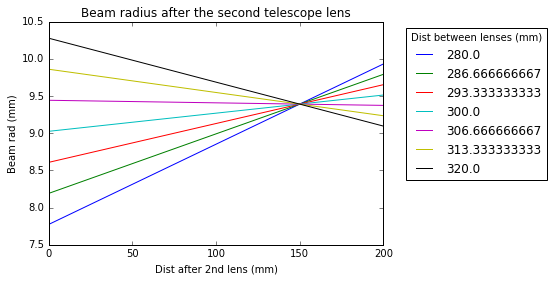

In [8]:
# Using the effective focal length formula EFL = f1*f2/(f1+f2-d), it turns out that the distance d for a unity telescope with f1=
# f2 = 150 mm is 294.375 mm for f_eff = 4000 

for sep in np.linspace(280,320,7):
    plt.plot(try_lenses(150,150,sep)[0],try_lenses(150,150,sep)[1])
plt.legend(np.linspace(280,320,7),bbox_to_anchor=(1.05, 1),loc=2,title="Dist between lenses (mm)")
plt.title("Beam radius after the second telescope lens")
plt.xlabel("Dist after 2nd lens (mm)")
plt.ylabel("Beam rad (mm)")
plt.show()

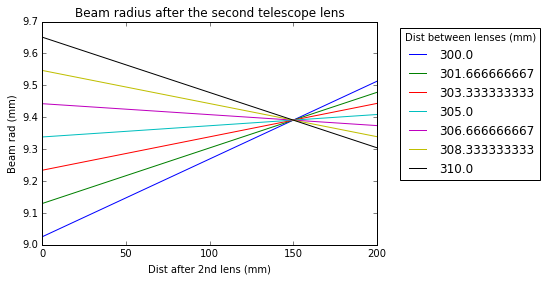

In [9]:
# Let's now zoom into the region where the beam becomes collimated
lens_separations = np.linspace(300,310,7)
for sep in lens_separations:
    plt.plot(try_lenses(150,150,sep)[0],try_lenses(150,150,sep)[1])
plt.legend(lens_separations,bbox_to_anchor=(1.05, 1),loc=2,title="Dist between lenses (mm)")
plt.title("Beam radius after the second telescope lens")
plt.xlabel("Dist after 2nd lens (mm)")
plt.ylabel("Beam rad (mm)")
plt.show()

Consequently, ~306 mm lens separation produces a collimated beam 

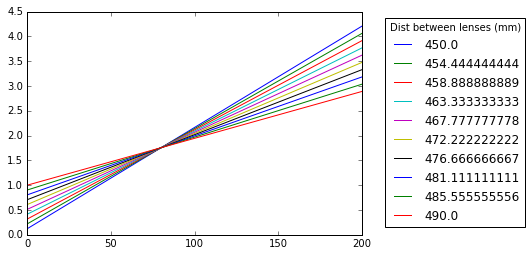

In [10]:
# Now let's use lenses with very different focal lengths, corresponding to a telescope with a large magnification. For example 
# f1 = 400, f2 = 80, then for f_eff = 4000 the simple formula says that we need d = 472

lens_separations = np.linspace(450,490,10)
for sep in lens_separations:
    plt.plot(try_lenses(400,80,sep)[0],try_lenses(400,80,sep)[1])
plt.legend(lens_separations,bbox_to_anchor=(1.05, 1),loc=2,title="Dist between lenses (mm)")
plt.show()

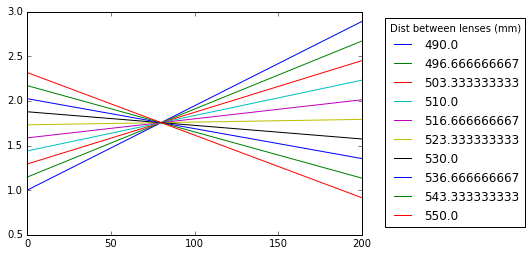

In [11]:
# Apparently the ABCD matrices give a different result from that obtained by the simple formula for the effective focal length
# We need larger separations to obtain a collimated beam, let's try that

lens_separations = np.linspace(490,550,10)
for sep in lens_separations:
    plt.plot(try_lenses(400,80,sep)[0],try_lenses(400,80,sep)[1])
plt.legend(lens_separations,bbox_to_anchor=(1.05, 1),loc=2,title="Dist between lenses (mm)")
plt.show()

This result means that the separation between the two lenses needs to be ~523 mm in order to produce a collimated beam at the output, and the beam rad will be ~1.75 mm 

Since now the two-lens setup also does function like a telescope and does also produce a smaller collimated beam, the second lens doesn't need to be a 2" lens, so we can try a different focal length to get a smaller beam rad, which will match an A15 collimator, for example (beam rad 1.385 mm according to Schafter Kirchhoff specs)

Let's try two lenses with f1 = 400, f2 = 60

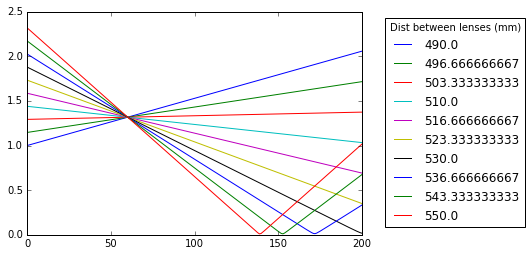

In [12]:
lens_separations = np.linspace(490,550,10)
for sep in lens_separations:
    plt.plot(try_lenses(400,60,sep)[0],try_lenses(400,60,sep)[1])
plt.legend(lens_separations,bbox_to_anchor=(1.05, 1),loc=2,title="Dist between lenses (mm)")
plt.show()

Consequently, using lenses of f = 400 (2") and f = 60 (1") at the distance of 503 mm, and the A15 collimator, we should be able to create the necessary beam profile for the Zeeman slower 

Fundamentally the mismatch between the actual beam size from the A15 collimator and the beam size found by this reverse propagation should be possible to correct to a large extent by moving the telescope forward or backward with respect to the end of the Zeeman slower 

Let's now proparage the beam in the normal direction, starting with the known size coming out of the A15 collimator to see that the profile is indeed what we would like
It's the 2-lens system from the figure above, with f1 = 60, f2 = 400, d = 503.4 mm 

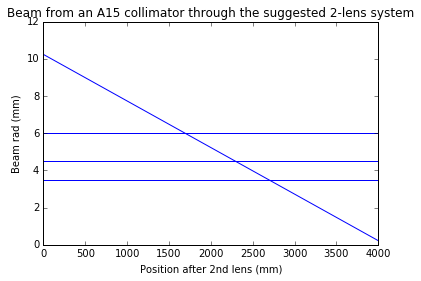

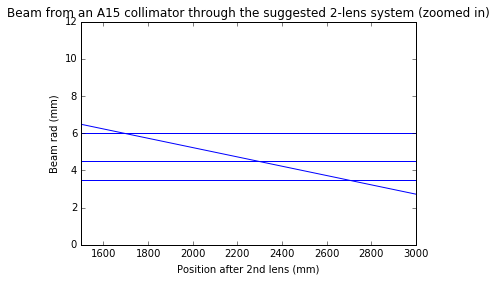

In [13]:
q_in_fw = ABCDeqs.q_param(lam,1.385,np.inf)
pts_after_fw = np.linspace(0,4000,1000)

l1_fw = ABCDeqs.lens_matrix(60)
space_betw_fw = ABCDeqs.space_matrix(503.4,1)
l2_fw = ABCDeqs.lens_matrix(400)
space_after_fw = [ABCDeqs.space_matrix(x,1) for x in pts_after_fw]
syst_matr_fw = [sa*l2_fw*space_betw_fw*l1_fw for sa in space_after_fw]

q_fin_fw = [ABCDeqs.propagate_q(q_in_fw,sm) for sm in syst_matr_fw]
waists_fw = [ABCDeqs.waist_from_q(q,lam) for q in q_fin_fw]

plt.plot(pts_after_fw,waists_fw)
plt.title("Beam from an A15 collimator through the suggested 2-lens system")
plt.xlabel("Position after 2nd lens (mm)")
plt.ylabel("Beam rad (mm)")
plt.axhline(y = 6)
plt.axhline(y = 4.5)
plt.axhline(y = 3.5)
plt.show()

plt.plot(pts_after_fw,waists_fw)
plt.title("Beam from an A15 collimator through the suggested 2-lens system (zoomed in)")
plt.xlabel("Position after 2nd lens (mm)")
plt.ylabel("Beam rad (mm)")
plt.xlim(1500,3000)
plt.axhline(y = 6)
plt.axhline(y = 4.5)
plt.axhline(y = 3.5)
plt.show()

The horizontal lines on the plot above denote beam rad of 6 mm (to pass through the end of the short ZS), 4.5 mm (to pass through the beginning of the long ZS) and 3.5 mm (to fit into the end of the diff. tube) 

We see that the distance between the 6 mm position and the 3.5 mm position is ~1m, which is a almost equal to the real distance from the end of the short ZS to the end of the diff. tube (1025 mm). This means that such a beam does satisfy the requirements for our ZS beam 


Getting back to reverse propagation now. Let's check the results for the available lenses of f=200 and f=250 of 2" size, and the other ones of f=30 and f=40 of 1" size 

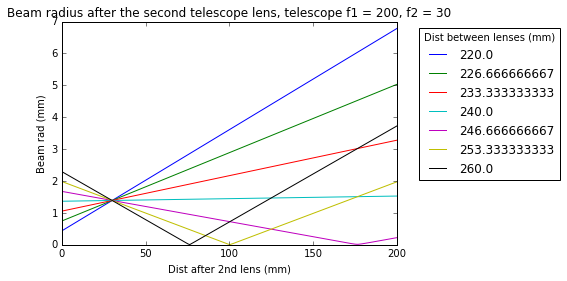

In [16]:
f1 = 200
f2 = 30 
distances = np.linspace(220,260,7)
for sep in distances:
    plt.plot(try_lenses(f1,f2,sep)[0],try_lenses(f1,f2,sep)[1])
plt.legend(distances,bbox_to_anchor=(1.05, 1),loc=2,title="Dist between lenses (mm)")
plt.title("Beam radius after the second telescope lens, telescope f1 = %.i, f2 = %.i"%(f1,f2))
plt.xlabel("Dist after 2nd lens (mm)")
plt.ylabel("Beam rad (mm)")
plt.show()

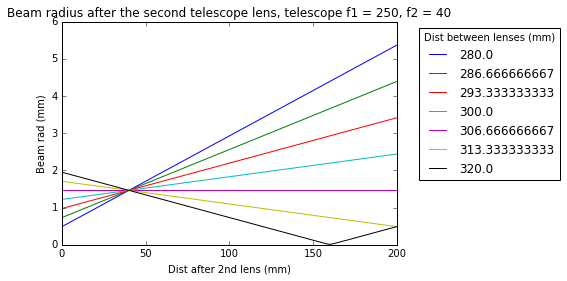

In [19]:
f1 = 250
f2 = 40 
distances = np.linspace(280,320,7)
for sep in distances:
    plt.plot(try_lenses(f1,f2,sep)[0],try_lenses(f1,f2,sep)[1])
plt.legend(distances,bbox_to_anchor=(1.05, 1),loc=2,title="Dist between lenses (mm)")
plt.title("Beam radius after the second telescope lens, telescope f1 = %.i, f2 = %.i"%(f1,f2))
plt.xlabel("Dist after 2nd lens (mm)")
plt.ylabel("Beam rad (mm)")
plt.show()